In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, mean_squared_error, 
                             confusion_matrix, classification_report)
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from datetime import datetime
from functools import partial
import shap
import itertools
import math
import json
import os
import warnings
import re
import pickle
import time

# LightGBM and XGBoost
import lightgbm as lgb
import xgboost as xgb
from xgboost import DMatrix

# TensorFlow / Keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Clustering
from sklearn.cluster import KMeans

# Displaying Images
from IPython.display import Image

# Ignore Warnings
warnings.filterwarnings("ignore")



/Users/wenwei/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/wenwei/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load Data
df = pd.read_csv("cleaned data/cleaned_data_split.csv")

In [5]:
ae_cols = ['default_profile', 'default_profile_image',
        'geo_enabled', 'lang', 'location', 'verified',
        'account_age_days', 'is_description_na', 'is_lang_na', 'is_lang_en',
       'is_location_unknown', 'creation_hour', 'creation_day_of_week', 'deviation_from_humans',
       'creation_month', 'creation_year', 'is_weekend', 'creation_quarter',
       'part_of_day', 'creation_week_of_year', 'is_beginning_of_month',
       'is_end_of_month', 'description_length', 'influencer_type',
       'favourites_per_day', 'favourites_activity',
       'mention_count', 'log_favourites_count', 'log_followers_count', 'log_friends_count',
       'log_statuses_count', 'log_average_tweets_per_day',
       'log_fol_to_friends_ratio', 'log_fol_to_tweets_ratio',
       'log_friends_to_tweets_ratio']

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import shap
import matplotlib.pyplot as plt


X = df[ae_cols].copy()

# Standardize the features for clustering and autoencoder
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use KMeans with a relatively high number of clusters
kmeans = KMeans(n_clusters=10, random_state=42)  # Adjust based on your dataset
df['cluster'] = kmeans.fit_predict(X_scaled)

# Calculate outlier scores based on cluster sizes
cluster_sizes = df['cluster'].value_counts()
small_clusters = cluster_sizes[cluster_sizes < (0.05 * len(df))].index  # Adjust the threshold as needed
df['is_cluster_outlier'] = df['cluster'].apply(lambda x: 1 if x in small_clusters else 0)

# Define Autoencoder Architecture
input_dim = X_scaled.shape[1]
encoding_dim = 4  # Size of the encoded representation

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder on non-outlier data identified by K-means
normal_data = X_scaled[df['is_cluster_outlier'] == 0]
autoencoder.fit(normal_data, normal_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Define Autoencoder Architecture
input_dim = X_scaled.shape[1]
encoding_dim = 4  # Size of the encoded representation

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder on non-outlier data identified by K-means
normal_data = X_scaled[df['is_cluster_outlier'] == 0]
autoencoder.fit(normal_data, normal_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Get reconstruction errors on the entire dataset
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean(np.square(X_scaled - reconstructions), axis=1)

# Set a threshold for outlier detection
threshold = np.percentile(reconstruction_errors, 95)  # Adjust as needed
df['is_autoencoder_outlier'] = (reconstruction_errors > threshold).astype(int)

# Final outlier flag
df['is_outlier'] = np.where((df['is_cluster_outlier'] == 1) | (df['is_autoencoder_outlier'] == 1), 1, 0)

# Use the full dataset with the outlier label for the surrogate model
df_surrogate = df.copy()
X_surrogate = df_surrogate[ae_cols]
y_surrogate = df_surrogate['is_outlier']

# Train a Decision Tree on the combined outlier data
surrogate_model = DecisionTreeClassifier(max_depth=5, random_state=42)  # Adjust depth based on interpretability needs
surrogate_model.fit(X_surrogate, y_surrogate)



Epoch 1/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step - loss: 0.9896 - val_loss: 0.8717
Epoch 2/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 0.7548 - val_loss: 0.8554
Epoch 3/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 0.7303 - val_loss: 0.8456
Epoch 4/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.7131 - val_loss: 0.8356
Epoch 5/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 0.6993 - val_loss: 0.8279
Epoch 6/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 0.7007 - val_loss: 0.8210
Epoch 7/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 0.7036 - val_loss: 0.8155
Epoch 8/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 0.6969 - val_loss: 0.8103
Epoch 9/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 0.6835 - val_loss: 0.8063
Epoch 10/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.6820 - val_loss: 0.8026
Epoch 11/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.6846 - val_loss: 0.7979
Epoch 12/50
890/890 ━━━━━━━━━━

DecisionTreeClassifier(max_depth=5, random_state=42)

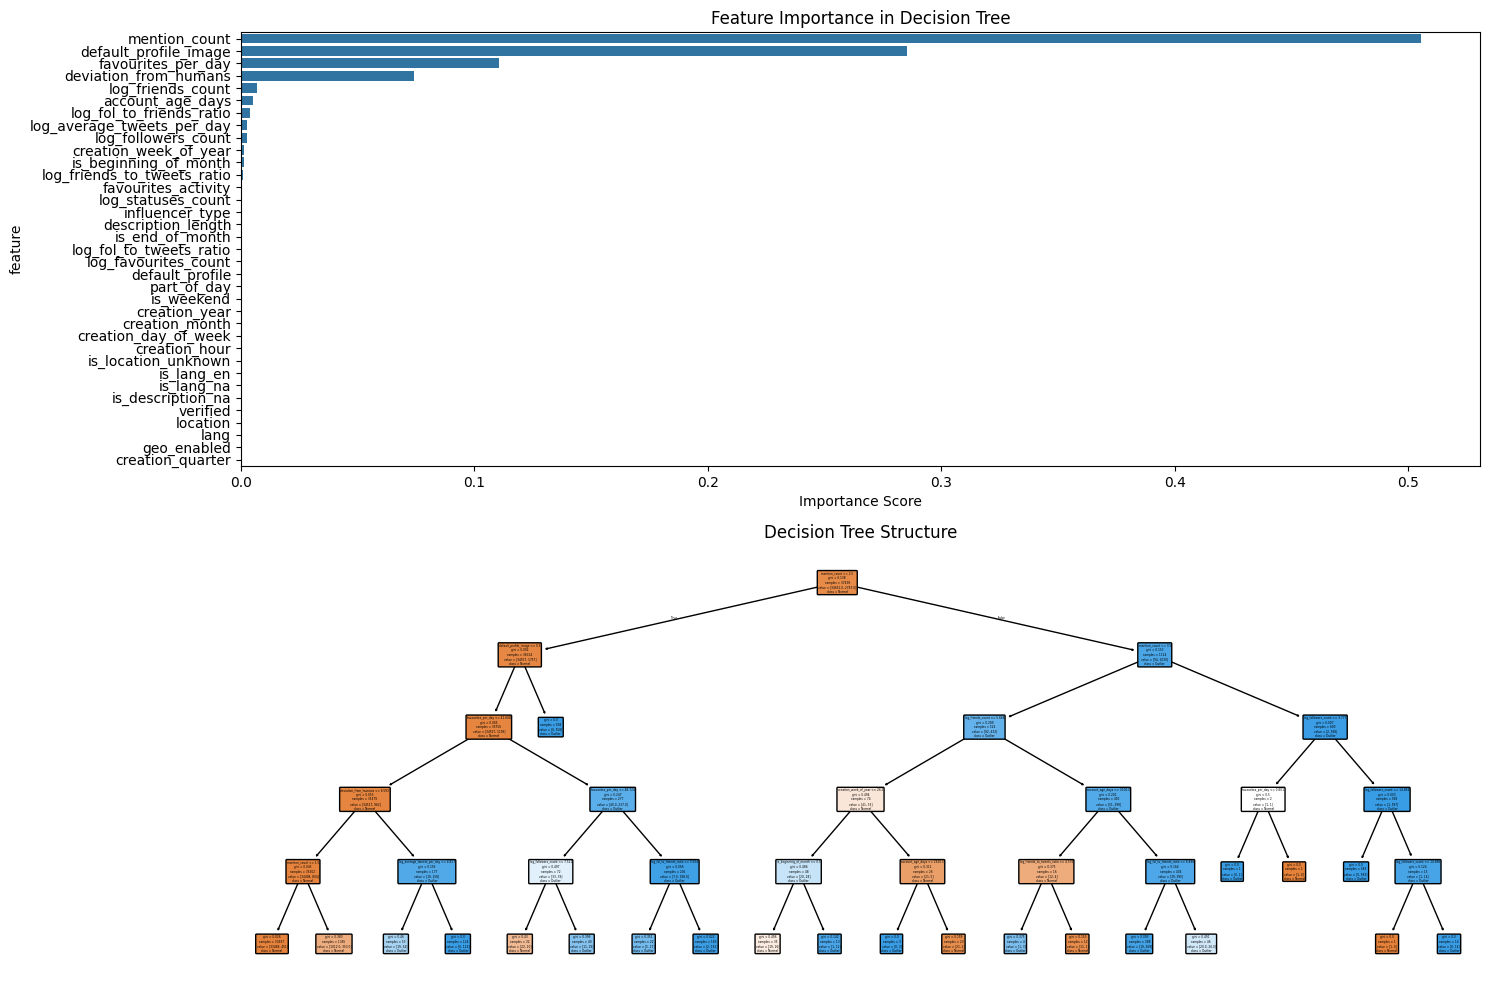


Decision Tree Analysis:

1. Node Statistics:
total_nodes: 43
leaf_nodes: 22
max_depth: 5

2. Feature Threshold Statistics:

mention_count:
  mean: 2.50
  min: 1.50
  max: 3.50
  count: 3

default_profile_image:
  mean: 0.50
  min: 0.50
  max: 0.50
  count: 1

favourites_per_day:
  mean: 30.38
  min: 0.80
  max: 48.72
  count: 3

deviation_from_humans:
  mean: 6.59
  min: 6.59
  max: 6.59
  count: 1

log_average_tweets_per_day:
  mean: 4.83
  min: 4.83
  max: 4.83
  count: 1

log_followers_count:
  mean: 10.27
  min: 3.78
  max: 14.90
  count: 4

log_fol_to_friends_ratio:
  mean: 3.50
  min: 0.50
  max: 6.50
  count: 2

log_friends_count:
  mean: 5.67
  min: 5.67
  max: 5.67
  count: 1

creation_week_of_year:
  mean: 26.50
  min: 26.50
  max: 26.50
  count: 1

is_beginning_of_month:
  mean: 0.50
  min: 0.50
  max: 0.50
  count: 1

account_age_days:
  mean: 2814.25
  min: 2620.50
  max: 3008.00
  count: 2

log_friends_to_tweets_ratio:
  mean: 4.58
  min: 4.58
  max: 4.58
  count: 1

3. 

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_decision_tree(model, X, feature_names, output_dict=False):
    """
    Comprehensive analysis of the decision tree model
    """
    # 1. Feature Importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # 2. Get decision rules as text
    tree_rules = export_text(model, feature_names=list(feature_names))
    
    # 3. Calculate feature threshold statistics
    feature_thresholds = {}
    n_nodes = model.tree_.node_count
    features = model.tree_.feature
    thresholds = model.tree_.threshold
    
    for i in range(n_nodes):
        if features[i] != -2:  # Not a leaf node
            feature_name = feature_names[features[i]]
            if feature_name not in feature_thresholds:
                feature_thresholds[feature_name] = []
            feature_thresholds[feature_name].append(thresholds[i])
    
    threshold_stats = {
        feature: {
            'mean': np.mean(values),
            'min': np.min(values),
            'max': np.max(values),
            'count': len(values)
        }
        for feature, values in feature_thresholds.items()
    }
    
    # 4. Get node statistics
    node_stats = {
        'total_nodes': model.tree_.node_count,
        'leaf_nodes': model.get_n_leaves(),
        'max_depth': model.get_depth()
    }
    
    if output_dict:
        return {
            'feature_importance': importance_df,
            'tree_rules': tree_rules,
            'threshold_stats': threshold_stats,
            'node_stats': node_stats
        }
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Feature Importance Plot
    plt.subplot(2, 1, 1)
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title('Feature Importance in Decision Tree')
    plt.xlabel('Importance Score')
    
    # 2. Decision Tree Visualization
    plt.subplot(2, 1, 2)
    plot_tree(model, feature_names=list(feature_names), 
             class_names=['Normal', 'Outlier'],
             filled=True, rounded=True)
    plt.title('Decision Tree Structure')
    
    plt.tight_layout()
    plt.show()
    
    # Print text-based analysis
    print("\nDecision Tree Analysis:")
    print("=" * 50)
    print("\n1. Node Statistics:")
    for key, value in node_stats.items():
        print(f"{key}: {value}")
    
    print("\n2. Feature Threshold Statistics:")
    for feature, stats in threshold_stats.items():
        if stats['count'] > 0:  # Only show features actually used in the tree
            print(f"\n{feature}:")
            for stat_name, stat_value in stats.items():
                print(f"  {stat_name}: {stat_value:.2f}" if isinstance(stat_value, float) 
                      else f"  {stat_name}: {stat_value}")
    
    print("\n3. Decision Rules:")
    print(tree_rules)

# Analyze the surrogate model
analyze_decision_tree(
    surrogate_model,
    X_surrogate,
    feature_names=ae_cols
)

y_pred = surrogate_model.predict(X_surrogate)
print("\n4. Model Performance:")
print(classification_report(df['account_type'], y_pred))
